In [114]:
# Dependencies
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import squarify
import requests
import json
import plotly.plotly as py
import gmaps
import gmaps.datasets
# Google API Key
from config import gkey
# Access maps with unique API key
gmaps.configure(api_key=gkey)

In [115]:
# Creating a dataframe from csv
df = pd.read_csv("Resources/survey_results_public.csv", low_memory=False)

In [116]:
# Cleaning the data
df_cleaned = df[['DevType','Hobby', 'OpenSource', 'Country', 'Student', 'Employment', 'FormalEducation',
                 'YearsCoding', 'UndergradMajor','Exercise', 'Gender', 'SexualOrientation',
       'EducationParents', 'RaceEthnicity', 'Age','YearsCodingProf']]


In [ ]:
def google_api_request(url, params=None):
    params = params or {}
    params['key'] = gkey
    result = requests.get(url, params=params).json()
    if 'error_message' in result:
        raise Exception(result['error_message'])
    return result['results']

def geocode_results(address):
    return google_api_request('https://maps.googleapis.com/maps/api/geocode/json', params={
        'address': address,
    })


In [4]:
# Geography
# Map of developers from each country
df_developer_country = pd.DataFrame()
df_developer_country['Country'] = df_cleaned['Country'].value_counts().index
df_developer_country['Count'] = df_cleaned['Country'].value_counts().values
df_developer_country['Code'] = ""
df_developer_country = df_developer_country[df_developer_country.Country != 'Other Country (Not Listed Above)']
df_developer_country.dropna(how='all')

,Country,Count
0,United States,20309
1,India,13721
2,Germany,6459
3,United Kingdom,6221
4,Canada,3393


In [5]:
df_code = pd.read_csv('country_code.csv')
for index, row in df_developer_country.iterrows():
    country = row['Code']
    for index2, row2 in df_code.iterrows():
        if country == row2['2let']:
            gender_df_list.loc[index, "Code3"] = row2['3let']

In [ ]:
# Loop through the cities_pd and run a lat/long search for each city
# for index, row in gender_df_list.iterrows():
#     country = row['Country'] 
#     results = geocode_results(f"{country}")
#     df_developer_country.loc[index, "Code"] = results[0]['address_components'][0]['short_name']



In [ ]:
df_code = pd.read_csv('country_code.csv')
for index, row in df_developer_country.iterrows():
    country = row['Code']
    for index2, row2 in df_code.iterrows():
        if country == row2['2let']:
            df_developer_country.loc[index, "Code3"] = row2['3let']

In [6]:
df = df_developer_country

data = [ dict(
        type = 'choropleth',
        locations = df['Code3'],
        z = df['Count'],
        text = df['Country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Number of Developers'),
      ) ]

layout = dict(
    title = 'Total Developers By Country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        autosize=True
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='developers-world-map' )

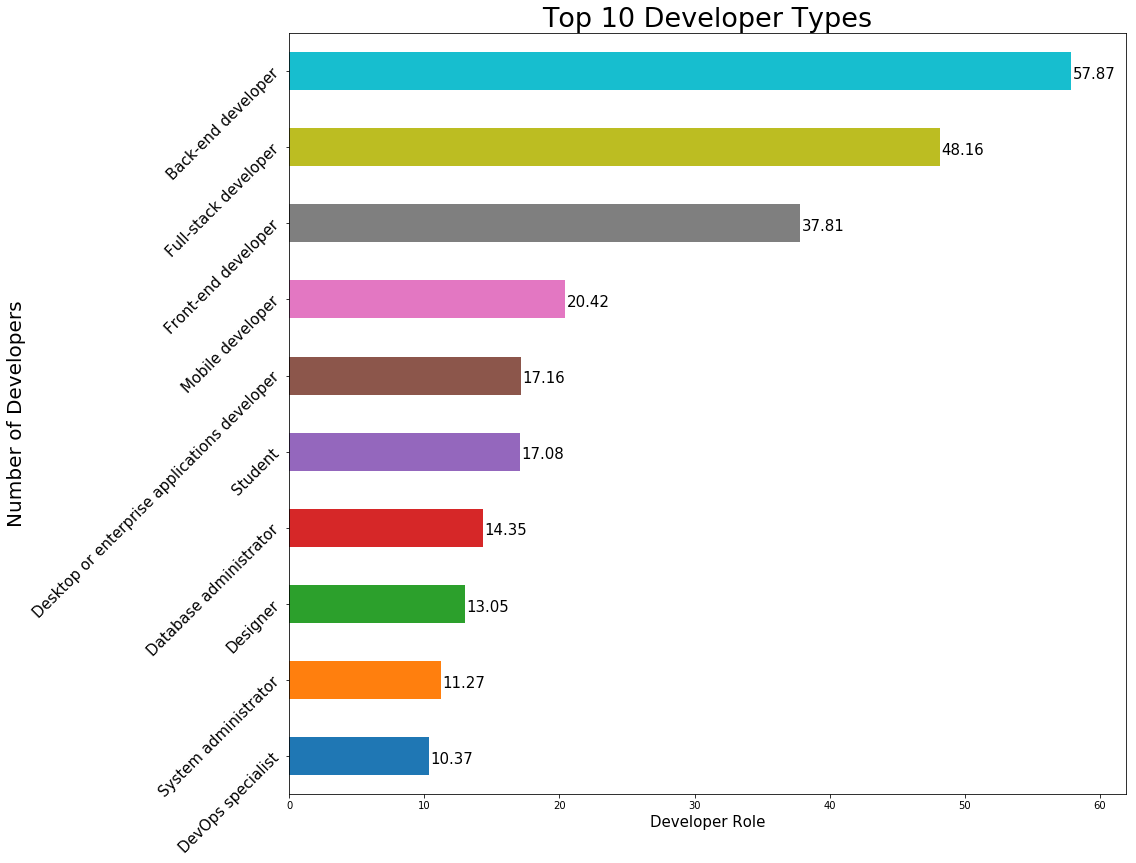

In [104]:
dev_type = df_cleaned['DevType'].dropna()
dev_role = {}
for roles in dev_type:
    role_list= roles.split(';')
    for role in role_list:
        dev_role[role] = (dev_role.get(role, 0)+1) 
dev_role_df = pd.DataFrame.from_dict(dev_role, orient='index', columns=['Number of Developers'])
total_developers = dev_type.count()

dev_role_df['Percentage'] = round(dev_role_df['Number of Developers']/total_developers*100,2)
explode = (0.1,0,0,0,0)
plt.figure(figsize=(15,14))
plt.margins(.07,.07)
dev_list = dev_role_df['Percentage'].sort_values(ascending=False)
ax = dev_list[:10].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Developer Types',fontsize=27)
plt.xlabel('Developer Role',fontsize=15)
plt.yticks(fontsize=15, rotation=45)
plt.ylabel('Number of Developers',fontsize=20)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.15, \
            str(round((i.get_width()), 2)), fontsize=15, color='black')

    
plt.savefig("Images/Top10DeveloperTypes.png")

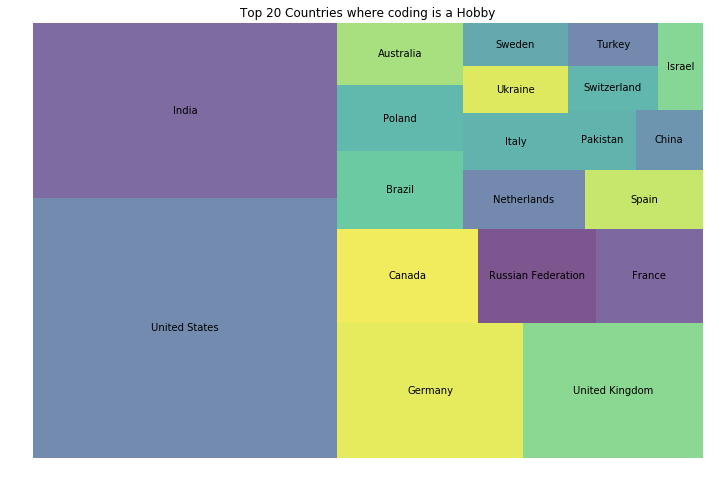

In [40]:
# Coding as Hobby
df_hobby = df_cleaned[['Country', 'Hobby']].dropna()
country = df_hobby['Country'].value_counts().index
value = df_hobby['Country'].value_counts().values
plt.figure(figsize=(12,8))
# If you have 2 lists
squarify.plot(sizes=value[:20], label=country[:20], alpha=.7)
plt.axis('off')
plt.title('Top 20 Countries where coding is a Hobby')
plt.show()

In [ ]:
# Open Source

Text(0.5,1,'Open Source Contribution')

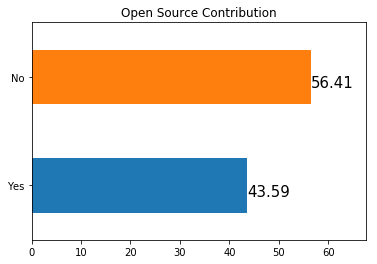

In [71]:
df_open_source = df_cleaned['OpenSource'].dropna()
total = df_open_source.count()
percentage = df_open_source.value_counts()/total*100
ax = percentage.sort_values().plot(kind='barh')
plt.margins(.2,.07)
# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.15, \
            str(round((i.get_width()), 2)), fontsize=15, color='black')
plt.title('Open Source Contribution')


In [ ]:
#EDUCATION

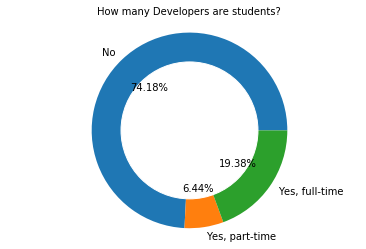

In [73]:
# How many developers are students
dev_stu = df_cleaned['Student'].dropna()
dev_student = {}
for role in dev_stu:
    dev_student[role] = (dev_student.get(role, 0)+1) 
dev_student_df = pd.DataFrame.from_dict(dev_student, orient='index',columns=['Students'])
total_developers = dev_stu.count()
dev_student_df

dev_student_df['Students'] = round(dev_student_df['Students']/total_developers*100,2)
dev_student_df['Students'].plot.pie(autopct = '%.2f%%')
plt.title('How many Developers are students?', fontsize=10)
plt.axis("equal")
plt.ylabel(" ")
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig("Images/StudentDevelopers.png")

(-1.1117691655511515,
 1.1005604364548167,
 -1.109732241105186,
 1.1067785659712486)

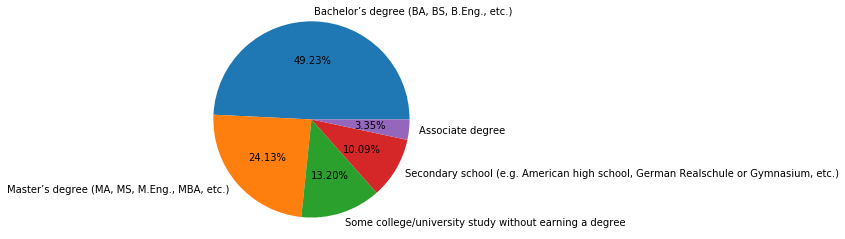

In [41]:
#Highest Degree done by Developers
degree_df = df_cleaned['FormalEducation'].dropna()
degree = degree_df.value_counts().index
count = degree_df.value_counts().values
plt.pie(x = count[:5], 
        labels = degree[:5], 
        autopct = '%.2f%%')
plt.axis('equal')

In [61]:
# Undergrad Major
undergrad_df = df_cleaned['UndergradMajor'].dropna()
degree = undergrad_df.value_counts().index
count = undergrad_df.value_counts().values
plt.barh(count,degree)
# undergrad_df.plot(kind='barh')
# plt.axis('equal')

Computer science, computer engineering, or software engineering          50336
Another engineering discipline (ex. civil, electrical, mechanical)        6945
Information systems, information technology, or system administration     6507
A natural science (ex. biology, chemistry, physics)                       3050
Mathematics or statistics                                                 2818
Web development or web design                                             2418
A business discipline (ex. accounting, finance, marketing)                1921
A humanities discipline (ex. literature, history, philosophy)             1590
A social science (ex. anthropology, psychology, political science)        1377
Fine arts or performing arts (ex. graphic design, music, studio art)      1135
I never declared a major                                                   693
A health science (ex. nursing, pharmacy, radiology)                        246
Name: UndergradMajor, dtype: int64

In [ ]:
# DEMOGRAPHICS

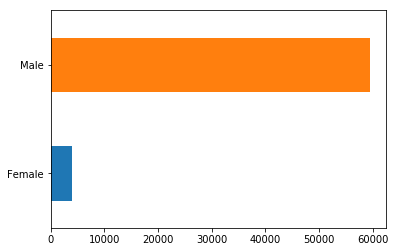

In [74]:
# Gender Analysis
gender_df = df_cleaned[['Country','Gender']].dropna()
male_female_df = gender_df['Gender'].where((gender_df['Gender'] == 'Male') | (gender_df['Gender'] == 'Female')).value_counts()
male_female_df.sort_values().plot(kind='barh')


              Country  count_female  count_male
0       United States        1288.0       13914
1               India         440.0        6213
2      United Kingdom         256.0        4260
3              Canada         208.0        2201
4             Germany         193.0        4205
5  Russian Federation          95.0        1632
6           Australia          85.0        1389
7              France          83.0        1629
8              Poland          73.0        1310
9         Netherlands          66.0        1212


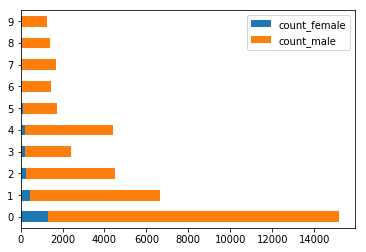

In [34]:
female_df = gender_df['Country'].loc[gender_df['Gender'] == 'Female'].value_counts()
male_df = gender_df['Country'].loc[gender_df['Gender'] == 'Male'].value_counts()
s = female_df + male_df 
male_df = pd.DataFrame({'Country':male_df.index, 'count':male_df.values})
female_df = pd.DataFrame({'Country':female_df.index, 'count':female_df.values})
gender_count_df = female_df.merge(male_df, how='outer', on='Country', suffixes=['_female','_male'])
count = gender_count_df.head(10)
print(count)
count.plot(kind='barh', stacked=True)
plt.savefig("Images/DevelopersGenderAnalysisBarChart.png")

In [42]:
# PARENTS EDUCATION LEVEL


Text(0.5,1,'Parents Education Level')

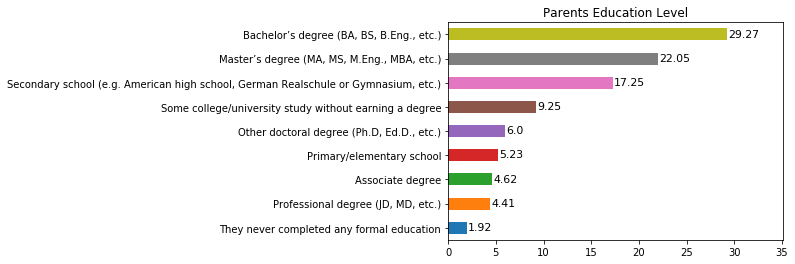

In [76]:
df_parents = df_cleaned['EducationParents'].dropna()
total = df_parents.count()
percentage = df_parents.value_counts()/total*100
ax = percentage.sort_values().plot(kind='barh')
plt.margins(.2,.07)
# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.15, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')
plt.title('Parents Education Level')

In [83]:
# experience and gender
df_cleaned.columns

Index(['DevType', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment',
       'FormalEducation', 'YearsCoding', 'UndergradMajor', 'Exercise',
       'Gender', 'SexualOrientation', 'EducationParents', 'RaceEthnicity',
       'Age', 'YearsCodingProf'],
      dtype='object')

         Experience  Count_female  Count_male
0         0-2 years          1463       14992
1         3-5 years          1082       15115
2         6-8 years           440        8554
3        9-11 years           267        5859
4       12-14 years           118        3418
5       15-17 years            88        2416
6       18-20 years            88        2297
7       21-23 years            44        1088
8  30 or more years            35        1042
9       24-26 years            27         717


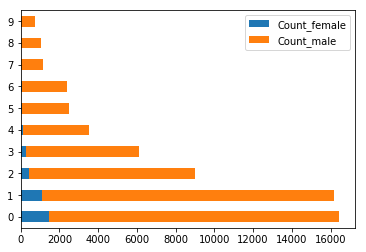

In [90]:
exp_gender_df = df_cleaned[['YearsCodingProf', 'Gender']]
female_exp_df = exp_gender_df['YearsCodingProf'].loc[exp_gender_df['Gender'] == 'Female'].value_counts()
male_exp_df = exp_gender_df['YearsCodingProf'].loc[exp_gender_df['Gender'] == 'Male'].value_counts()
male_exp_df = pd.DataFrame({'Experience':male_exp_df.index, 'Count':male_exp_df.values})
female_exp_df = pd.DataFrame({'Experience':female_exp_df.index, 'Count':female_exp_df.values})
gender_exp_df = female_exp_df.merge(male_exp_df, how='outer', on='Experience', suffixes=['_female','_male'])
count = gender_exp_df.head(10)
print(count)
count.plot(kind='barh', stacked=True)
plt.savefig("Images/DevelopersGenderExperianceAnalysisBarChart.png")

In [93]:
# Developer Role and Gender


In [45]:
# Age

In [46]:
# Age and Experience by Country